In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 50
pd.set_option('max_columns', 50)
sns.set(style='ticks', context='talk')
sns.set(rc={"figure.figsize": (8, 8)})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

More magic:
  
`%alias_magic t time`<br>
`?str.replace()`<br>
`%run ./two-histograms.ipynb`<br>
`!ls`<br>
`%lsmagic`<br>

Also https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

# `fetch_mldata`

In [2]:
%env SCIKIT_LEARN_DATA=/home/maxim/bin/scikit_learn_data

env: SCIKIT_LEARN_DATA=/home/maxim/bin/scikit_learn_data


In [3]:
from sklearn.datasets import fetch_mldata
iris = fetch_mldata('iris')
iris.keys()
iris.data.shape
iris.target.shape

dict_keys(['DESCR', 'COL_NAMES', 'target', 'data'])

(150, 4)

(150,)

# `SGDClassifier`

In [4]:
mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5.shape
y_train_5[:18]

(60000,)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False])

In [6]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [7]:
# it's a linear model
sgd.coef_.shape
sgd.intercept_.shape
sgd.loss

(1, 784)

(1,)

'hinge'

# `cross_val_score`


In [8]:
X_train.shape
y_train_5.shape

(60000, 784)

(60000,)

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96315, 0.9589 , 0.94515])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def my_cross_val_score(sgd):
    result = []
    skfolds = StratifiedKFold(n_splits=3, random_state=42)
    for train_index, test_index in skfolds.split(X_train, y_train_5):
        clone_clf = clone(sgd)
        X_train_folds = X_train[train_index]
        y_train_folds = (y_train_5[train_index])
        X_test_fold = X_train[test_index]
        y_test_fold = (y_train_5[test_index])

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        result.append(n_correct / len(y_pred))
    return result

my_cross_val_score(sgd)

[0.96315, 0.9589, 0.94515]

Link: [Stratification on CV.SE](https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)

# `cross_val_predict`, `confusion_matrix`

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [12]:
y_train_pred.shape
y_train_pred
y_train_5.shape
y_train_5

(60000,)

array([False,  True, False, ..., False, False, False])

(60000,)

array([False, False, False, ..., False, False, False])

In [13]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)
confusion

array([[52830,  1749],
       [  907,  4514]])

In [14]:
# A good example for 3 classes:
confusion_matrix(y_true=[2, 0, 2, 2, 0, 1], y_pred=[0, 0, 2, 2, 0, 2])

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

# `precision_score`, `recall_score`

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred)
confusion[1][1] / (confusion[1][1] + confusion[0][1])

recall_score(y_train_5, y_train_pred)
confusion[1][1] / (confusion[1][1] + confusion[1][0])

f1_score(y_train_5, y_train_pred)
confusion[1][1] / (confusion[1][1] + (confusion[1][0] + confusion[0][1]) / 2.0)

0.7207408590132525

0.7207408590132525

0.8326876959970485

0.8326876959970485

0.7726805888394385

0.7726805888394386

# `precision_recall_curve`, `roc_curve`, `roc_auc_score`

In [16]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

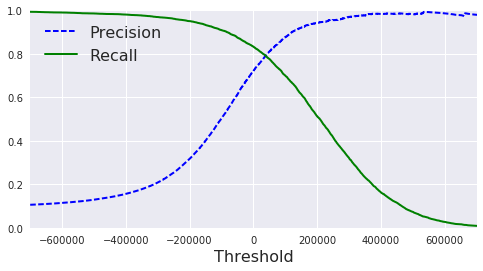

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

fig = plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
lims = plt.xlim([-700000, 700000])
plt.show()

In [18]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.8382810878139921

0.7448810182623132

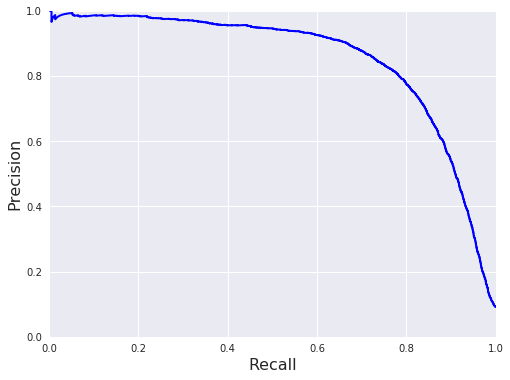

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

fig = plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_thresholds = roc_curve(y_train_5, y_scores)

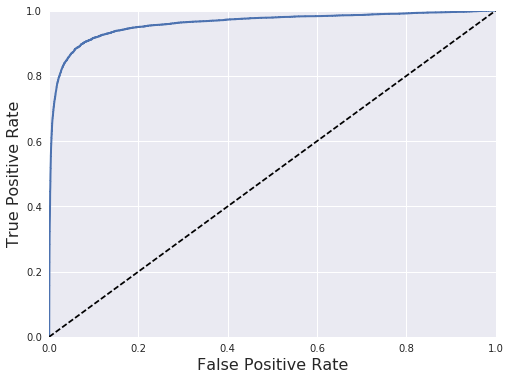

In [21]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

fig = plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores)

0.9614080287803718

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=1)
y_probs_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

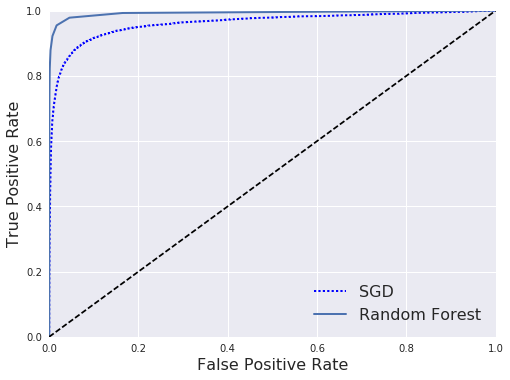

In [24]:
fig = plt.figure(figsize=(8, 6))
plot = plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
legend = plt.legend(loc="lower right", fontsize=16)
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926858677111265

# `OneVsOneClassifier`

In [26]:
sgd.fit(X_train, y_train)
sgd.predict([X[36000]])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

array([5.])

In [27]:
sgd.decision_function([X[36000]])

array([[-106844.56766892, -428694.76188877, -442391.10960346,
        -294410.9161258 , -422710.47298349,   22330.0036266 ,
        -786468.32613386, -219066.97045952, -484569.89376685,
        -631569.95384138]])

In [28]:
from sklearn.multiclass import OneVsOneClassifier
ovo_sgd = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=10))
ovo_sgd.fit(X_train, y_train)
ovo_sgd.predict([X[36000]])
len(ovo_sgd.estimators_)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

array([5.])

45

In [29]:
forest.fit(X_train, y_train)
forest.predict([X[36000]])
forest.predict_proba([X[36000]])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

array([5.])

array([[0. , 0. , 0.1, 0.3, 0. , 0.6, 0. , 0. , 0. , 0. ]])

In [30]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

array([0.86587682, 0.86034302, 0.82752413])

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90921816, 0.91119556, 0.9079862 ])

In [32]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
confusion = confusion_matrix(y_train, y_train_pred)
confusion

array([[5737,    3,   24,    6,   10,   51,   39,   10,   40,    3],
       [   1, 6481,   45,   26,    6,   45,    6,    9,  112,   11],
       [  57,   38, 5361,  100,   76,   24,   80,   62,  143,   17],
       [  55,   43,  142, 5326,    2,  243,   35,   48,  139,   98],
       [  20,   30,   35,    9, 5381,    9,   52,   29,   78,  199],
       [  75,   49,   36,  179,   75, 4637,   95,   28,  148,   99],
       [  39,   25,   46,    2,   41,  106, 5609,    8,   42,    0],
       [  23,   22,   70,   30,   54,    9,    7, 5786,   16,  248],
       [  50,  162,   73,  172,   16,  164,   53,   27, 4978,  156],
       [  43,   33,   28,   92,  159,   35,    2,  208,   77, 5272]])

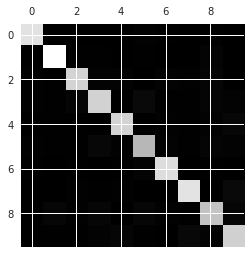

In [33]:
plt.matshow(confusion, cmap=plt.cm.gray)
plt.show();

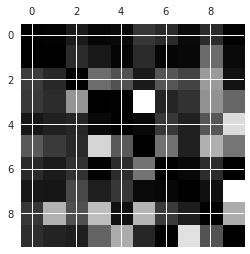

In [34]:
row_sums = confusion.sum(axis=1, keepdims=True)
norm_confusion = confusion / row_sums
np.fill_diagonal(norm_confusion, 0)

plt.matshow(norm_confusion, cmap=plt.cm.gray)
plt.show();

# `KNeighborsClassifier`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([X[36000]])